## N-BaIoT Botnet Detection with LightGBM (Final Version)

This notebook trains a high-performance LightGBM model for botnet detection on the N-BaIoT dataset. 

### Workflow:
1.  **Data Loading**: Loads randomized samples from the pre-split `train` and `validation` directories on S3.
2.  **Preprocessing**: Uses `RobustScaler` to handle outliers and prepares the data for training.
3.  **Training**: Trains a `LightGBM` classifier with built-in class imbalance handling and early stopping.
4.  **Evaluation**: Assesses the model's performance on the validation set.
5.  **Saving**: Saves the final trained model and scaler for deployment.

In [1]:
!pip install lightgbm scikit-learn pandas numpy s3fs joblib seaborn matplotlib pyarrow

### 1. Configuration and Imports

In [2]:
import os
import joblib
import json
import numpy as np
import pandas as pd
import s3fs
import pyarrow.dataset as ds
import lightgbm as lgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- S3/MinIO Configuration ---
S3_ENDPOINT_URL = os.environ.get("S3_ENDPOINT_URL", "http://minio:9000")
S3_ACCESS_KEY = os.environ.get("S3_ACCESS_KEY", "minio_access_key")
S3_SECRET_KEY = os.environ.get("S3_SECRET_KEY", "minio_secret_key")

# --- Path Configuration ---
SOURCE_DATA_PATH = "processed/iot_botnet_data"
TRAIN_DATA_PATH = os.path.join(SOURCE_DATA_PATH, "train")
VAL_DATA_PATH = os.path.join(SOURCE_DATA_PATH, "validation")

ARTIFACTS_DIR = "app/saved_assets"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

SCALER_PATH = os.path.join(ARTIFACTS_DIR, "lgbm_nbiot_scaler.gz")
FEATURE_LIST_PATH = os.path.join(ARTIFACTS_DIR, "lgbm_features.json")
MODEL_PATH = os.path.join(ARTIFACTS_DIR, "lgbm_nbiot_model.joblib")

# --- Data Sampling and Model Hyperparameters ---
SAMPLE_SIZE_TRAIN = 1000000
SAMPLE_SIZE_VAL = 200000

# --- S3 Filesystem Object ---
s3 = s3fs.S3FileSystem(
    key=S3_ACCESS_KEY,
    secret=S3_SECRET_KEY,
    client_kwargs={'endpoint_url': S3_ENDPOINT_URL}
)

### 2. Data Loading and Preprocessing Utilities

In [3]:
import random
import pyarrow.parquet as pq

def load_random_sample(path, sample_size, s3_filesystem):
    """
    Loads a random sample from a multi-file Parquet dataset in a memory-safe way.
    """
    print(f"Loading random sample of {sample_size:,} from {path}...")
    # Get a list of all parquet files in the directory
    all_files = s3_filesystem.glob(f"{path}/*.parquet")
    
    # Shuffle the list of files to ensure randomness
    random.shuffle(all_files)
    
    df_list = []
    rows_loaded = 0
    
    # Load files one by one until we have enough rows
    for file_path in all_files:
        df = pq.read_table(file_path, filesystem=s3_filesystem).to_pandas()
        df_list.append(df)
        rows_loaded += len(df)
        if rows_loaded >= sample_size:
            break
            
    # Combine the loaded dataframes and take a final precise sample
    full_df = pd.concat(df_list, ignore_index=True)
    return full_df.sample(n=min(sample_size, len(full_df)), random_state=42)

def get_or_create_scaler(scaler_path, s3_filesystem):
    """Loads a scaler or fits a new one using RobustScaler."""
    # This function remains largely the same, but we'll use the new loader
    if os.path.exists(scaler_path):
        print(f"Loading existing scaler from {scaler_path}")
        scaler = joblib.load(scaler_path)
        with open(FEATURE_LIST_PATH, 'r') as f:
            numerical_features = json.load(f)
        return scaler, numerical_features
    else:
        print("Scaler not found. Detecting features and fitting a new RobustScaler...")
        scaler = RobustScaler()
        # Use our new random loader to get a sample for fitting the scaler
        sample_df = load_random_sample(TRAIN_DATA_PATH, 200000, s3_filesystem)
        try:
            numerical_features = sample_df.select_dtypes(include=np.number).columns.tolist()
            if 'label' in numerical_features:
                numerical_features.remove('label')
            
            print(f"Detected {len(numerical_features)} numerical features.")
            with open(FEATURE_LIST_PATH, 'w') as f:
                json.dump(numerical_features, f)
            print(f"Feature list saved to {FEATURE_LIST_PATH}")

            X_sample = sample_df[numerical_features].values
            scaler.fit(X_sample)
            print(f"Scaler fitted on {len(X_sample)} samples.")
            joblib.dump(scaler, scaler_path)
            print(f"Scaler saved to {scaler_path}")
            return scaler, numerical_features
        except Exception as e:
            print(f"An error occurred while fitting the scaler: {e}")
            return None, None

### 3. Load Data and Prepare for Training

In [4]:
# Get the scaler and the list of features to use
scaler, feature_list = get_or_create_scaler(SCALER_PATH, s3)

# Load random samples for training and validation using the new memory-safe function
train_df = load_random_sample(TRAIN_DATA_PATH, SAMPLE_SIZE_TRAIN, s3)
val_df = load_random_sample(VAL_DATA_PATH, SAMPLE_SIZE_VAL, s3)

# Prepare labels: attack = 1, benign = 0
y_train = (train_df['label'] == 'attack').astype(int)
y_val = (val_df['label'] == 'attack').astype(int)

# Prepare features using the consistent feature list
X_train = train_df[feature_list]
X_val = val_df[feature_list]

print("\nScaling data...")
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Data preparation complete.")

Scaler not found. Detecting features and fitting a new RobustScaler...
Loading random sample of 200,000 from processed/iot_botnet_data/train...
Detected 115 numerical features.
Feature list saved to app/saved_assets/lgbm_features.json
Scaler fitted on 200000 samples.
Scaler saved to app/saved_assets/lgbm_nbiot_scaler.gz
Loading random sample of 1,000,000 from processed/iot_botnet_data/train...
Loading random sample of 200,000 from processed/iot_botnet_data/validation...

Scaling data...


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


Data preparation complete.


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


### 4. Train the LightGBM Model

In [5]:
print("--- Training LightGBM Model ---")

# CORRECTED: Use the known global counts for the entire dataset for an accurate ratio
count_benign = 555932
count_attack = 6506674
imbalance_ratio = count_benign / count_attack
print(f"Using scale_pos_weight for imbalance: {imbalance_ratio:.4f}")

lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=imbalance_ratio,
    n_jobs=-1,
    random_state=42
)

lgbm.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(10, verbose=True)]
)

--- Training LightGBM Model ---
Using scale_pos_weight for imbalance: 0.0854
[LightGBM] [Info] Number of positive: 913281, number of negative: 86719
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29324
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.913281 -> initscore=2.354371
[LightGBM] [Info] Start training from score 2.354371
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 1


LGBMClassifier(learning_rate=0.05, metric='auc', n_estimators=1000, n_jobs=-1,
               objective='binary', random_state=42,
               scale_pos_weight=0.08544027255706986)

### 5. Evaluate and Save the Model


--- LightGBM Performance on Validation Set ---

Classification Report:
              precision    recall  f1-score   support

  Benign (0)       1.00      1.00      1.00     12089
  Attack (1)       1.00      1.00      1.00    187911

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000


Confusion Matrix:


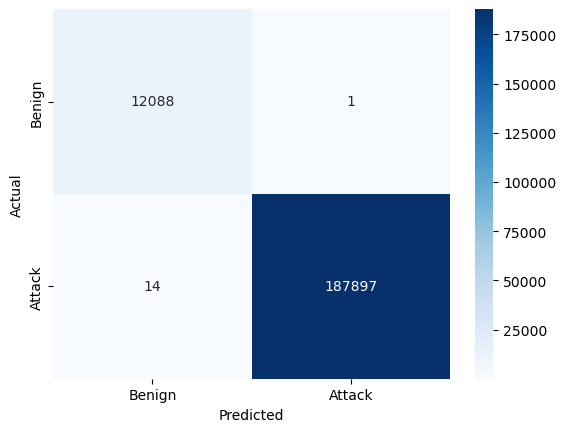


Saving trained LightGBM model to app/saved_assets/lgbm_nbiot_model.joblib
Model saved successfully.


In [6]:
print("\n--- LightGBM Performance on Validation Set ---")
preds = lgbm.predict(X_val_scaled)

print("\nClassification Report:")
print(classification_report(y_val, preds, target_names=['Benign (0)', 'Attack (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nSaving trained LightGBM model to {MODEL_PATH}")
joblib.dump(lgbm, MODEL_PATH)
print("Model saved successfully.")